In [1]:
from datasets import load_dataset

In [2]:
emotions = load_dataset("emotion")

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions['train']

In [5]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [7]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


## From Datasets to DataFrames

In [8]:
import pandas as pd

In [9]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)


df['label_name'] = df['label'].apply(label_int2str)

df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [11]:
!pip3 install matplotlib

In [12]:
import matplotlib.pyplot as plt

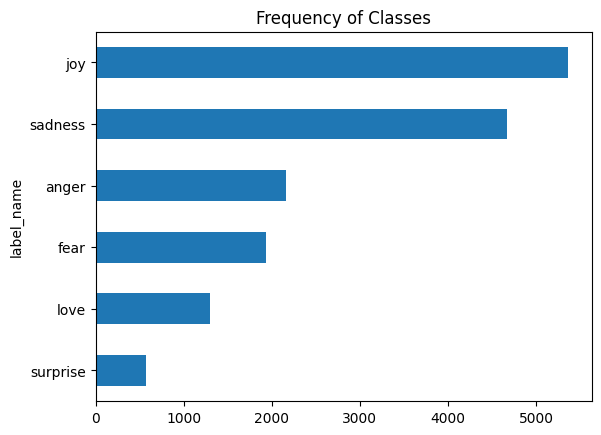

In [13]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Here, we are going to keep the unbalanced class for simplicity. Will explore Imbalanced-learn library. In general, there are several ways to deal with the class imbalance problem:
- Randomly oversample the minority class
- Randomly undersample the majority class
- Gather more labeled data from the underrepresent class

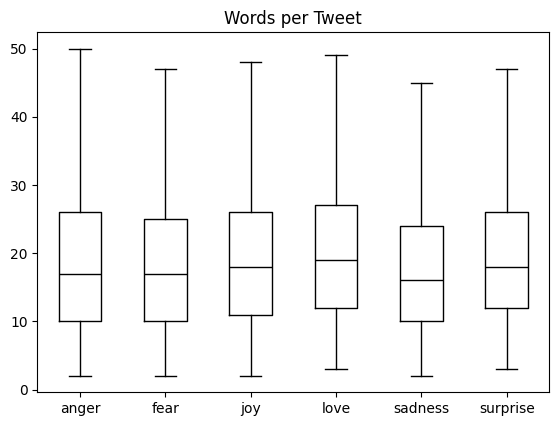

In [14]:
df['Words per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False,
           showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

## Converting raw texts into format suitable for Transformers
Raw text -> tokens -> encoded as numerical values

In [15]:
emotions.reset_format()

In [16]:
!pip3 install transformers==4.49.0

## Subword tokenization
Best of both worlds (character and work tokenization):
- Split rare words into smaller units to allow model to deal with complex words and misspellings
- keep frequent words as unique entities so that we keep the length of our inputs to a manageable size

In [17]:
from transformers import AutoTokenizer

In [63]:
from transformers import DistilBertTokenizer

In [64]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # Based on WordPiece


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [65]:
example_text = "Tokenizing text is a core task of NLP"

In [66]:
encoded_text = tokenizer(example_text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [67]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

In [68]:
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [69]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


In [70]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

In [71]:
def tokenize(batch, text_column_name="text"):
    return tokenizer(batch[text_column_name], padding=True, truncation=True)

In [72]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [73]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [74]:
from transformers import AutoModel
import torch

In [75]:
model = 'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model).to(device)

In [76]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [77]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [79]:
inputs = {k:v.to(device) for k, v in inputs.items()}

In [80]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [81]:
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


## Using last hidden state as feature for a classifier model
- Get the last hidden state

In [82]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}

    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [83]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [84]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Creating a feature matrix

In [85]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [47]:
!pip3 install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for umap-learn from https://files.pythonhosted.org/packages/3c/8f/671c0e1f2572ba625cbcc1faeba9435e00330c3d6962858711445cf1e817/umap_learn-0.5.7-py3-none-any.whl.metadata
  Obtaining dependency information for numba>=0.51.2 from https://files.pythonhosted.org/packages/be/1b/c33dc847d475d5b647b4ad5aefc38df7a72283763f4cda47745050375a81/numba-0.61.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/d2/53/d23a97e0a2c690d40b165d1062e2c4ccc796be458a1ce59f6ba030434663/pynndescent-0.5.13-py3-none-any.whl.metadata
  Obtaining dependency information for llvmlite<0.45,>=0.44.0dev0 from https://files.pythonhosted.org/packages/ff/ec/506902dc6870249fbe2466d9cf66d531265d0f3a1157213c8f986250c033/llvmlite-0.44.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.

In [54]:
from umap import UMAP

In [55]:
from sklearn.preprocessing import MinMaxScaler

In [86]:
X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.067581,5.892817,0
1,-3.097168,4.756070,0
2,5.230436,2.470878,3
3,-2.473304,2.626826,2
4,-3.482390,2.798851,3


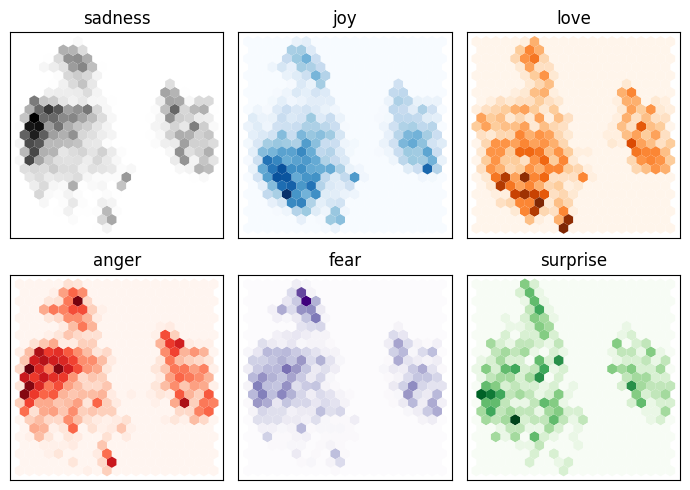

In [87]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Training a logistic regression

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6345

## Create a dummy classifier
and score it with this model for comparison. Here the dummy classifier will be picking the most frequent class all the time

In [91]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

## Investigate the performance of the model
by looking at the confusion matrix

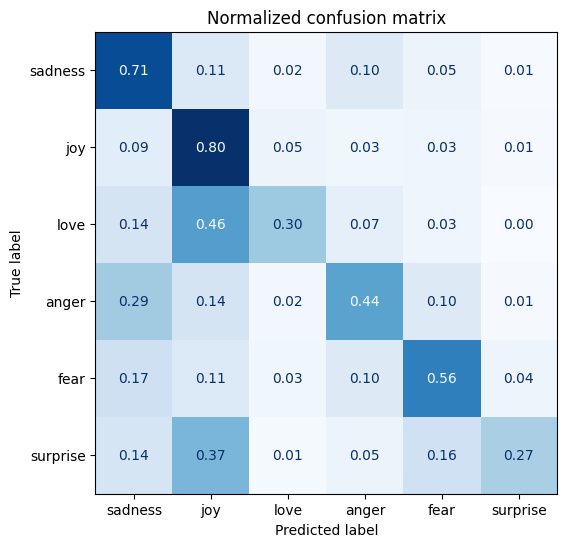

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)